## Homoscedastic uncertainty

### Example of learning the aleatoric homoscedastic uncertainty by learning a simple linear regression

In [1]:
#!pip install keras==2.0.8
from keras.callbacks import TensorBoard
from keras.layers import Input, Dense, concatenate, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD, RMSprop, Nadam
from keras.initializers import RandomNormal
from keras.layers import multiply, add, Reshape, RepeatVector
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


First we create some samples from 0 to 40 and add some noise. In this case we have two variables with the same noise distribution, x and z, that we'll use to show that gimas can be calculated using two variables as inputs.

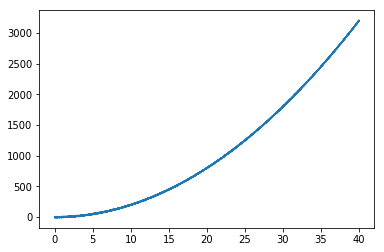

In [2]:
NUMBER_OF_SAMPLES = 10000
x = np.linspace(0, 40, NUMBER_OF_SAMPLES)#, dtype="int32")  # 100000 values between 0 and 100
deltax = np.random.normal(0, 2, x.size)
z = np.linspace(0, 40, NUMBER_OF_SAMPLES)
deltaz = np.random.normal(0, 3, z.size)

y = 2 * x * z + deltax + deltaz
plt.plot(x, y)
plt.show()

First we try a model without calculating the sigma and plot some results.

Epoch 1/150
10000/10000 [==============================] - 0s - loss: 2046683.6568     
Epoch 2/150
10000/10000 [==============================] - 0s - loss: 1999193.6776     
Epoch 3/150
10000/10000 [==============================] - 0s - loss: 1952626.4566     
Epoch 4/150
10000/10000 [==============================] - 0s - loss: 1906538.0292     
Epoch 5/150
10000/10000 [==============================] - 0s - loss: 1861291.6048     
Epoch 6/150
10000/10000 [==============================] - 0s - loss: 1816799.5564     
Epoch 7/150
10000/10000 [==============================] - 0s - loss: 1772969.6652     
Epoch 8/150
10000/10000 [==============================] - 0s - loss: 1729672.4592     
Epoch 9/150
10000/10000 [==============================] - 0s - loss: 1687440.6366     
Epoch 10/150
10000/10000 [==============================] - 0s - loss: 1646046.3934     
Epoch 11/150
10000/10000 [==============================] - 0s - loss: 1605503.4784     
Epoch 12/150
10000/10000 [====

10000/10000 [==============================] - 0s - loss: 34229.6740     
Epoch 95/150
10000/10000 [==============================] - 0s - loss: 31032.0882     
Epoch 96/150
10000/10000 [==============================] - 0s - loss: 28059.7575     
Epoch 97/150
10000/10000 [==============================] - 0s - loss: 25297.1534     
Epoch 98/150
10000/10000 [==============================] - 0s - loss: 22721.8616     
Epoch 99/150
10000/10000 [==============================] - 0s - loss: 20330.0183     
Epoch 100/150
10000/10000 [==============================] - 0s - loss: 18143.5083     
Epoch 101/150
10000/10000 [==============================] - 0s - loss: 16123.3114     
Epoch 102/150
10000/10000 [==============================] - 0s - loss: 14279.6767     
Epoch 103/150
10000/10000 [==============================] - 0s - loss: 12605.4122     
Epoch 104/150
10000/10000 [==============================] - 0s - loss: 11079.2129     
Epoch 105/150
10000/10000 [========================

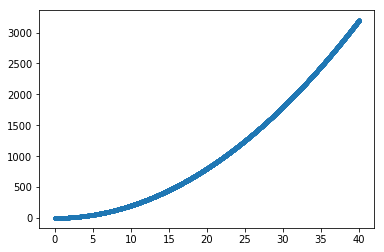

In [3]:
raw_input1 = Input(shape=(1,))
raw_input2 = Input(shape=(1,))
product = multiply([raw_input1,raw_input2])
raw_preds = Dense(1, activation='linear', name="preds")(product)
adam = Adam(lr=0.0003)
rawmodel = Model(inputs=[raw_input1,raw_input2],outputs=raw_preds)
rawmodel.compile(optimizer=adam, loss='mean_squared_error')
rawmodel.fit([x, z], y, batch_size=128, epochs=150, shuffle=True)
raw_result = rawmodel.predict([x, z])
plt.plot(x, raw_result[:,0],'.')
plt.show()

These are the functions used to include the calculation of the sigmas in the loss.
Note that we use the trick of concatenating the sigma to the ouput, so the prediction is at index 0 and the sigma is at index 1 of the resulting output.

In [4]:
def aleatoric_loss(y_true, y_pred):
    sigma = y_pred[:, 1]
    epsilon = 1e-6
    y_pred_prima = y_pred[:, 0]
    output_value = ((K.square(y_pred_prima - y_true[:, 0])) / (K.square(sigma)+ epsilon)) + K.log(K.square(sigma) + epsilon)
    return K.mean(output_value, axis=-1)

def aleatoric_rms(y_true, y_pred):
    y_pred_prima = y_pred[:, 0]
    y_true_prima = y_true[:, 0]
    output_value = K.square(y_pred_prima - y_true_prima)
    return K.mean(output_value, axis=-1)

Then we try a model where the sigmas are computed. In this case we have one sigma that don't belong to any of the inputs. Sigma is trained in the loss together with the mean squared error of the labels and the predictions.

In [5]:
input1 = Input(shape=(1,))
input2 = Input(shape=(1,))
input_sigma = Input(shape=(1,))
product = multiply([input1,input2])
preds = Dense(1, activation='linear', name="preds")(product)
sigma = Dense(1, activation='linear', name="sigma", kernel_initializer=RandomNormal(mean=1.0, stddev=0.05, seed=None), use_bias=True)(input_sigma)

aleatoric_output = concatenate([preds, sigma])
adam = Adam(lr=0.0003)
model = Model(inputs=[input1,input2,input_sigma],outputs=aleatoric_output)
model.compile(optimizer=adam, loss=aleatoric_loss, metrics=[aleatoric_rms])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
input_4 (InputLayer)             (None, 1)             0                                            
____________________________________________________________________________________________________
multiply_2 (Multiply)            (None, 1)             0           input_3[0][0]                    
                                                                   input_4[0][0]                    
____________________________________________________________________________________________________
input_5 (InputLayer)             (None, 1)             0                                   

In [6]:
BATCH_SIZE = 64
model.fit([x,z,np.ones(NUMBER_OF_SAMPLES)], np.expand_dims(y, axis=1).repeat(2, axis=1), batch_size=BATCH_SIZE, epochs=400, shuffle=True)

Epoch 1/400
10000/10000 [==============================] - 0s - loss: 5379077.9516 - aleatoric_rms: 6624446.7824     
Epoch 2/400
10000/10000 [==============================] - 0s - loss: 4546166.4280 - aleatoric_rms: 6466683.3448     
Epoch 3/400
10000/10000 [==============================] - 0s - loss: 3934189.1636 - aleatoric_rms: 6320075.7548     
Epoch 4/400
10000/10000 [==============================] - 0s - loss: 3465629.6056 - aleatoric_rms: 6182917.7304     
Epoch 5/400
10000/10000 [==============================] - 0s - loss: 3092284.0696 - aleatoric_rms: 6052791.4848     
Epoch 6/400
10000/10000 [==============================] - 0s - loss: 2786894.8488 - aleatoric_rms: 5928496.2456     
Epoch 7/400
10000/10000 [==============================] - 0s - loss: 2532132.0540 - aleatoric_rms: 5809261.2832     
Epoch 8/400
10000/10000 [==============================] - 0s - loss: 2315221.1404 - aleatoric_rms: 5693943.1056     
Epoch 9/400
10000/10000 [==============================]

10000/10000 [==============================] - 0s - loss: 65450.2382 - aleatoric_rms: 1012562.2562     
Epoch 70/400
10000/10000 [==============================] - 0s - loss: 61351.3389 - aleatoric_rms: 966241.0108     
Epoch 71/400
10000/10000 [==============================] - 0s - loss: 57456.1756 - aleatoric_rms: 920968.1846     
Epoch 72/400
10000/10000 [==============================] - 0s - loss: 53760.0831 - aleatoric_rms: 876801.5774     
Epoch 73/400
10000/10000 [==============================] - 0s - loss: 50267.6937 - aleatoric_rms: 833910.9300     
Epoch 74/400
10000/10000 [==============================] - 0s - loss: 46961.9430 - aleatoric_rms: 792205.3748     
Epoch 75/400
10000/10000 [==============================] - 0s - loss: 43821.5829 - aleatoric_rms: 751520.3267     
Epoch 76/400
10000/10000 [==============================] - 0s - loss: 40851.2264 - aleatoric_rms: 712013.7380     
Epoch 77/400
10000/10000 [==============================] - 0s - loss: 38048.0499 - 

10000/10000 [==============================] - 0s - loss: 3.9537 - aleatoric_rms: 18.4073     
Epoch 142/400
10000/10000 [==============================] - 0s - loss: 3.9533 - aleatoric_rms: 18.3978     
Epoch 143/400
10000/10000 [==============================] - 0s - loss: 3.9529 - aleatoric_rms: 18.3877     
Epoch 144/400
10000/10000 [==============================] - 0s - loss: 3.9525 - aleatoric_rms: 18.3767     
Epoch 145/400
10000/10000 [==============================] - 0s - loss: 3.9520 - aleatoric_rms: 18.3646     
Epoch 146/400
10000/10000 [==============================] - 0s - loss: 3.9514 - aleatoric_rms: 18.3514     
Epoch 147/400
10000/10000 [==============================] - 0s - loss: 3.9509 - aleatoric_rms: 18.3378     
Epoch 148/400
10000/10000 [==============================] - 0s - loss: 3.9502 - aleatoric_rms: 18.3218     
Epoch 149/400
10000/10000 [==============================] - 0s - loss: 3.9496 - aleatoric_rms: 18.3060     
Epoch 150/400
10000/10000 [======

10000/10000 [==============================] - 0s - loss: 3.7609 - aleatoric_rms: 14.2465     
Epoch 216/400
10000/10000 [==============================] - 0s - loss: 3.7561 - aleatoric_rms: 14.1850     
Epoch 217/400
10000/10000 [==============================] - 0s - loss: 3.7540 - aleatoric_rms: 14.1878     
Epoch 218/400
10000/10000 [==============================] - 0s - loss: 3.7480 - aleatoric_rms: 14.1057     
Epoch 219/400
10000/10000 [==============================] - 0s - loss: 3.7440 - aleatoric_rms: 14.0748     
Epoch 220/400
10000/10000 [==============================] - 0s - loss: 3.7369 - aleatoric_rms: 13.9774     
Epoch 221/400
10000/10000 [==============================] - 0s - loss: 3.7320 - aleatoric_rms: 13.9355     
Epoch 222/400
10000/10000 [==============================] - 0s - loss: 3.7272 - aleatoric_rms: 13.9009     
Epoch 223/400
10000/10000 [==============================] - 0s - loss: 3.7219 - aleatoric_rms: 13.8596     
Epoch 224/400
10000/10000 [======

10000/10000 [==============================] - 0s - loss: 3.5714 - aleatoric_rms: 13.0833     
Epoch 291/400
10000/10000 [==============================] - 0s - loss: 3.5780 - aleatoric_rms: 13.1700     
Epoch 292/400
10000/10000 [==============================] - 0s - loss: 3.5727 - aleatoric_rms: 13.1014     
Epoch 293/400
10000/10000 [==============================] - 0s - loss: 3.5747 - aleatoric_rms: 13.1266     
Epoch 294/400
10000/10000 [==============================] - 0s - loss: 3.5736 - aleatoric_rms: 13.1130     
Epoch 295/400
10000/10000 [==============================] - 0s - loss: 3.5725 - aleatoric_rms: 13.0984     
Epoch 296/400
10000/10000 [==============================] - 0s - loss: 3.5753 - aleatoric_rms: 13.1353     
Epoch 297/400
10000/10000 [==============================] - 0s - loss: 3.5745 - aleatoric_rms: 13.1248     
Epoch 298/400
10000/10000 [==============================] - 0s - loss: 3.5725 - aleatoric_rms: 13.0975     
Epoch 299/400
10000/10000 [======

10000/10000 [==============================] - 0s - loss: 3.5712 - aleatoric_rms: 13.0818     
Epoch 365/400
10000/10000 [==============================] - 0s - loss: 3.5718 - aleatoric_rms: 13.0883     
Epoch 366/400
10000/10000 [==============================] - 0s - loss: 3.5741 - aleatoric_rms: 13.1192     
Epoch 367/400
10000/10000 [==============================] - 0s - loss: 3.5731 - aleatoric_rms: 13.1060      ETA: 0s - loss: 3.5785 - aleatoric_rms: 1
Epoch 368/400
10000/10000 [==============================] - 0s - loss: 3.5710 - aleatoric_rms: 13.0785     
Epoch 369/400
10000/10000 [==============================] - 0s - loss: 3.5729 - aleatoric_rms: 13.1039     
Epoch 370/400
10000/10000 [==============================] - 0s - loss: 3.5723 - aleatoric_rms: 13.0950     
Epoch 371/400
10000/10000 [==============================] - 0s - loss: 3.5746 - aleatoric_rms: 13.1255     
Epoch 372/400
10000/10000 [==============================] - 0s - loss: 3.5728 - aleatoric_rms: 13.1

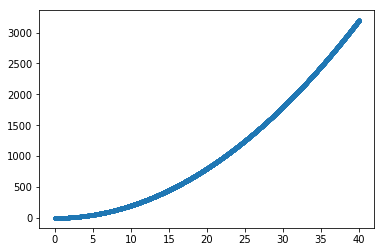

In [7]:
result = model.predict([x,z,np.ones(NUMBER_OF_SAMPLES)])
plt.plot(x, result[:,0],'.')
plt.show()

Here we are the homoscedastic uncertainty:

In [8]:
model_sigmas_x = Model(inputs=[input_sigma], outputs=sigma)
sigmas_x = model_sigmas_x.predict(np.ones(1))
sigmas_x[0][0]

3.6168621

In [9]:
rawmodel.layers[3].get_weights()

[array([[ 1.99790025]], dtype=float32), array([ 2.00287795], dtype=float32)]

In [10]:
model.layers[4].get_weights()

[array([[ 1.99983776]], dtype=float32), array([ 0.1385545], dtype=float32)]

In [11]:
rawmodel.predict([np.array([2]),np.ones(1)])

array([[ 5.99867821]], dtype=float32)

In [12]:
model.predict([np.array([2]),np.ones(1),np.ones(1)])

array([[ 4.13822985,  3.61686206]], dtype=float32)